In [18]:
from IPython import display
import os
import subprocess
from rdkit import Chem
from rdkit import RDConfig
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolAlign
from rdkit.Chem import rdShapeHelpers
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import PyMol
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import copy
import pprint

In [13]:
showfeatpath = os.path.join(RDConfig.RDCodeDir, 'Chem/Features/ShowFeats.py')
# Before align
v = PyMol.MolViewer()
v.DeleteAll()
process = subprocess.Popen(['python', showfeatpath, '--writeFeats','/raid/yyw/PharmDiGress/data/target_mol.sdf'], stdout=subprocess.PIPE)
stdout = process.communicate()[0]
png=v.GetPNG()
display.display(png)

ConnectionRefusedError: [Errno 111] Connection refused

In [14]:
showfeatpath 

'/home/ipmgpu2022b/software/miniconda3/envs/digress/lib/python3.9/site-packages/rdkit/Chem/Features/ShowFeats.py'

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.metrics import r2_score 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn import neighbors
import xgboost as xgb
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble

def compute_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024)
    return list(fingerprint)

def model_function(regr, X_train, y_train, X_test, y_test):
    pca = PCA(n_components=2)
    X_predict_result = regr.predict(X_test)
    plt.figure(figsize=(14,4))
    X_train_pca = pca.fit_transform(X_train)
    X_train_pca = np.vstack((X_train_pca.T, y_train.T)).T
    df_pca = pd.DataFrame(X_train_pca, columns=['1st_Component','2n_Component','LD50 predict value'])   #把降维后的数据和标签进行组合
    df_pca.head()
    plt.figure(figsize=(6, 6))  #定义输出图像大小
    sns.scatterplot(data=df_pca, hue='LD50 predict value',x='1st_Component',y='2n_Component')   #画散点图，定义X/Y轴
    plt.rcParams['xtick.direction'] = 'in'  #plt.rcParams主要作用是设置画的图的分辨率，大小等信息
    plt.rcParams['ytick.direction'] = 'in'
    plt.title('PCA visualization of features')  #定义标题
    plt.legend(loc='best')  #在最合适的地方显示便签
    # plt.savefig('PCA visualization of features.jpg')  #保存图片
    plt.show()
    plt.scatter(y_test, X_predict_result.reshape(-1,1))
    plt.xlabel('acute toxicity in test dataset')
    plt.ylabel('predict value of acute toxicity')
    plt.show()
    print('R2 score: {}'.format(r2_score(y_test, X_predict_result)))
    print("Mean Squared Error:", mean_squared_error(y_test.flatten(), X_predict_result))
    return X_predict_result

In [2]:
data = pd.read_csv("/raid/yyw/PharmDiGress/data/Acute_Toxicity_rat_oral_LD50.csv")
X_train = data['SMILES'].values.tolist()
y_train = data['rat_oral_LD50'].values.reshape(-1,1)

#divide training set and test set
fingerprints = [compute_fingerprint(smiles) for smiles in X_train]
fingerprints = np.array(fingerprints)
scaler = preprocessing.MinMaxScaler()
fingerprints = scaler.fit_transform(fingerprints)
y_train = scaler.fit_transform(y_train)
train_set,test_set,train_label,test_label = train_test_split(fingerprints,y_train,test_size = 0.2,random_state = 0)


/home/ipmgpu2022b/software/miniconda3/envs/digress/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ipmgpu2022b/software/miniconda3/envs/digress/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ipmgpu2022b/software/miniconda3/envs/digress/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ipmgpu2022b/software/miniconda3/envs/digress/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: D

best parameters: GradientBoostingRegressor(max_depth=7, n_estimators=500)


<Figure size 1400x400 with 0 Axes>

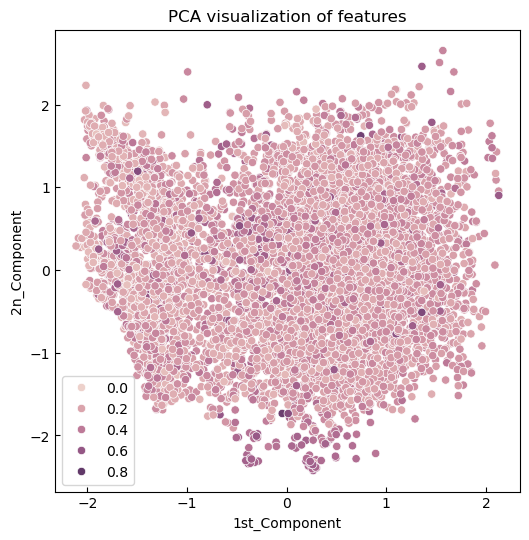

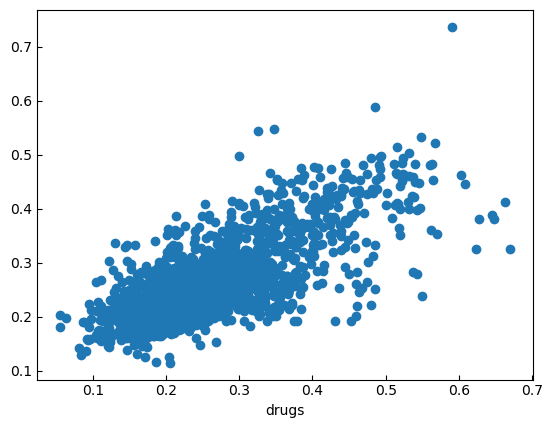

R2 score: 0.21185897030353995
Mean Squared Error: 0.004001977058674777


In [76]:
#Gradient Boosting Random Forest Regressor
param_grid = {
    'max_depth': [3,5,7],
    'n_estimators': [500, 700, 900],
    'learning_rate': [0.01, 0.1, 0.5]
}

GBR_reg = ensemble.GradientBoostingRegressor()
grid_search = GridSearchCV(GBR_reg, param_grid, cv=5, scoring='r2')
grid_search.fit(train_set, train_label)
print('best parameters:', grid_search.best_estimator_)
best_model = grid_search.best_estimator_
gbr_pred = model_function(best_model, train_set, train_label, test_set, test_label)

/home/ipmgpu2022b/software/miniconda3/envs/digress/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Figure size 1400x400 with 0 Axes>

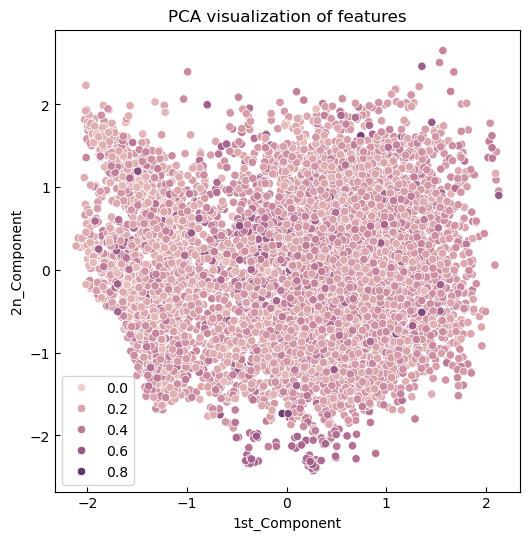

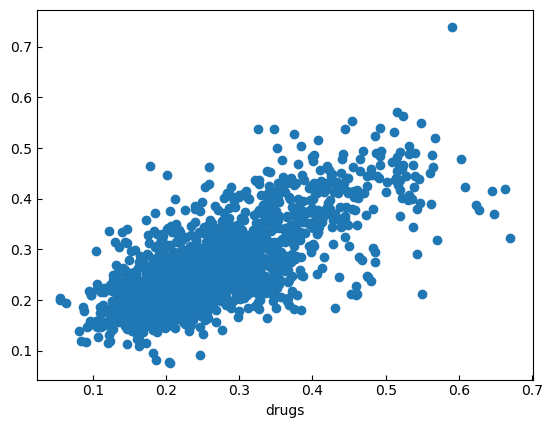

R2 score: 0.5116644129572482
Mean Squared Error: 0.004268381641005904


In [83]:
GBR_reg = ensemble.GradientBoostingRegressor(max_depth=7, n_estimators=500, learning_rate=0.3)
GBR_reg.fit(train_set, train_label)
gbr_pred = model_function(GBR_reg, train_set, train_label, test_set, test_label)

/home/ipmgpu2022b/software/miniconda3/envs/digress/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ipmgpu2022b/software/miniconda3/envs/digress/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ipmgpu2022b/software/miniconda3/envs/digress/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ipmgpu2022b/software/miniconda3/envs/digress/lib/python3.9/site-packages/sklearn/utils/v

best parameters: {'C': 0.1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}


<Figure size 1400x400 with 0 Axes>

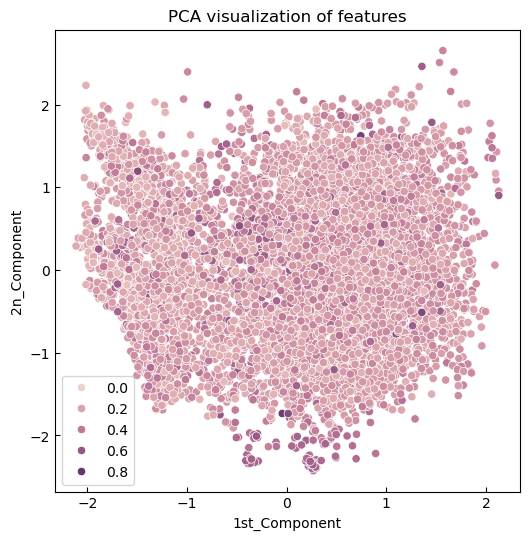

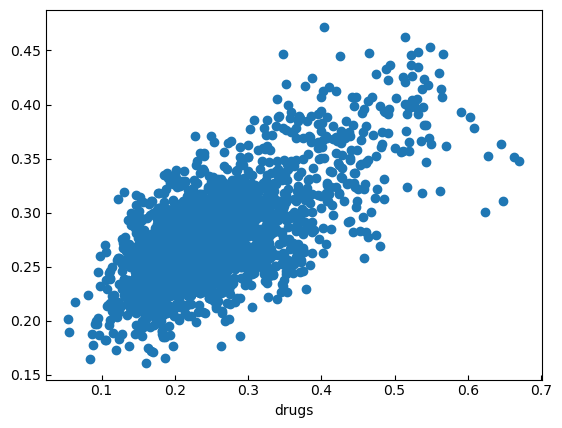

R2 score: 0.367968282116935
Mean Squared Error: 0.005524382520394361


In [84]:
##SVR
svr_reg = SVR()
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2, 0.5]
}
grid_search = GridSearchCV(svr_reg, param_grid, cv=5, scoring='r2')
grid_search.fit(train_set, train_label)
print('best parameters:', grid_search.best_params_)
best_model = grid_search.best_estimator_
svr_pred = model_function(best_model, train_set, train_label, test_set, test_label)

/home/ipmgpu2022b/software/miniconda3/envs/digress/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ipmgpu2022b/software/miniconda3/envs/digress/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ipmgpu2022b/software/miniconda3/envs/digress/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ipmgpu2022b/software/miniconda3/envs/digress/lib/python3.9/site-packages/sklearn/utils/v

best parameters: {'C': 0.1, 'epsilon': 0.01}


<Figure size 1400x400 with 0 Axes>

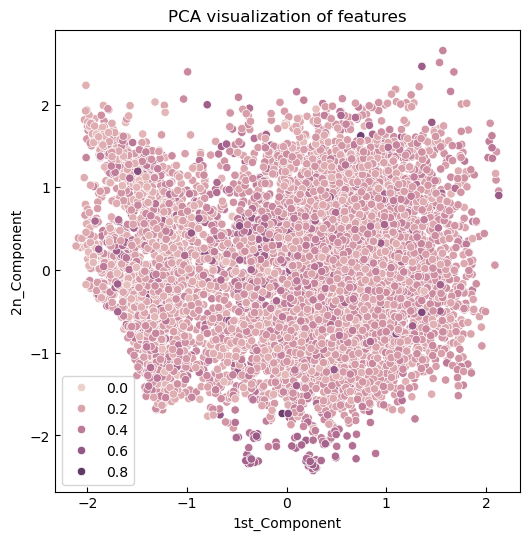

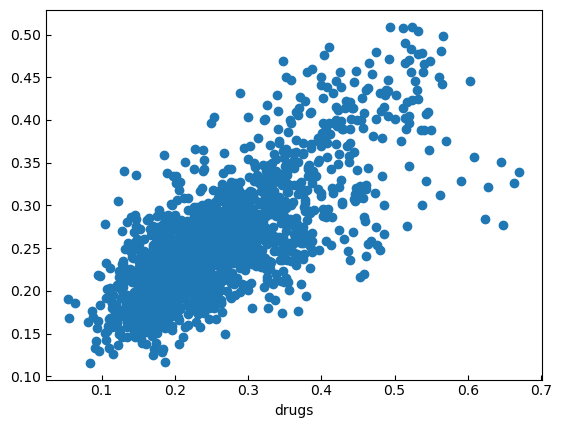

R2 score: 0.5514162406862346
Mean Squared Error: 0.00392092391689787


In [86]:
##SVR
svr_reg = SVR(kernel='rbf', gamma='scale')
param_grid = {
    'C': [0.01, 0.05, 0.1],
    'epsilon': [0.01, 0.05, 0.1]
}
grid_search = GridSearchCV(svr_reg, param_grid, cv=5, scoring='r2')
grid_search.fit(train_set, train_label)
print('best parameters:', grid_search.best_params_)
best_model = grid_search.best_estimator_
svr_pred = model_function(best_model, train_set, train_label, test_set, test_label)

best parameters: {'algorithm': 'kd_tree', 'n_neighbors': 5, 'weights': 'distance'}


<Figure size 1400x400 with 0 Axes>

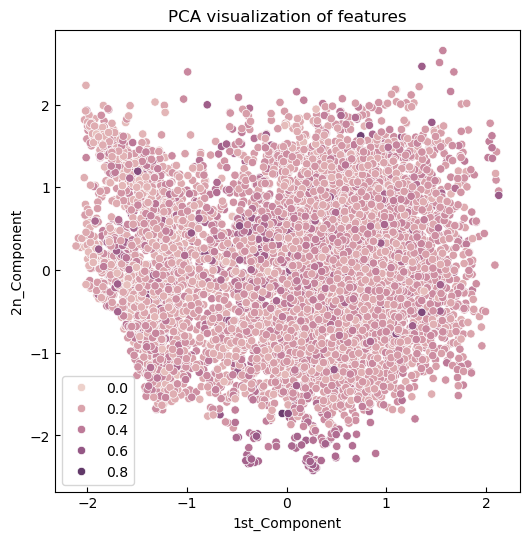

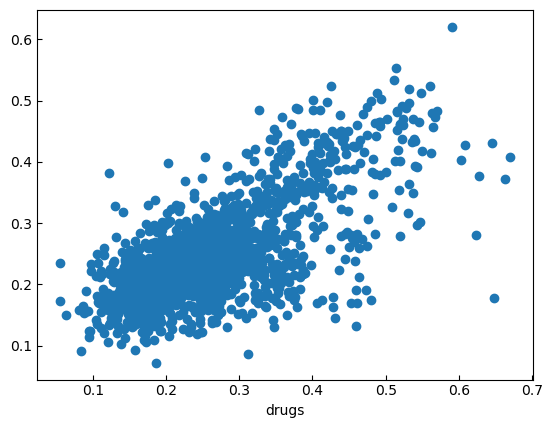

R2 score: 0.4655874128482901
Mean Squared Error: 0.00467112562804301


In [85]:
### K Neighbors Regressor
knn_reg = neighbors.KNeighborsRegressor()
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
grid_search = GridSearchCV(knn_reg, param_grid, cv=5, scoring='r2')
grid_search.fit(train_set, train_label)
print('best parameters:', grid_search.best_params_)
best_model = grid_search.best_estimator_
knn_pred = model_function(best_model, train_set, train_label, test_set, test_label)

/home/ipmgpu2022b/software/miniconda3/envs/digress/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Figure size 1400x400 with 0 Axes>

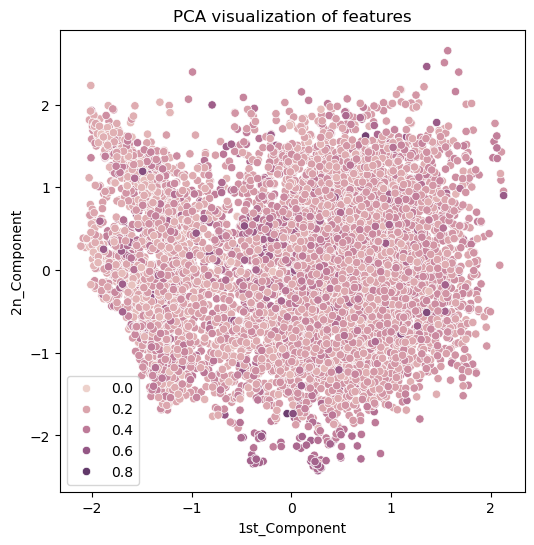

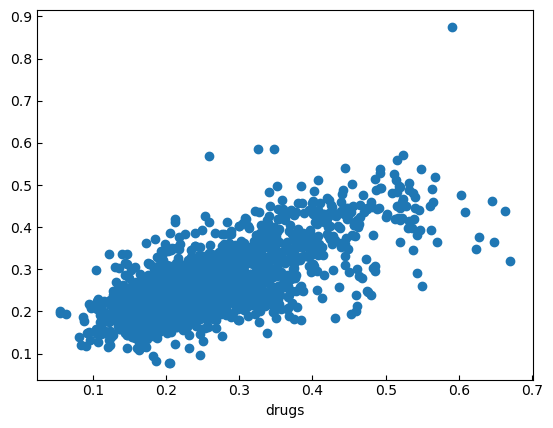

R2 score: 0.5085596467848968
Mean Squared Error: 0.004295519386608131


/home/ipmgpu2022b/software/miniconda3/envs/digress/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Figure size 1400x400 with 0 Axes>

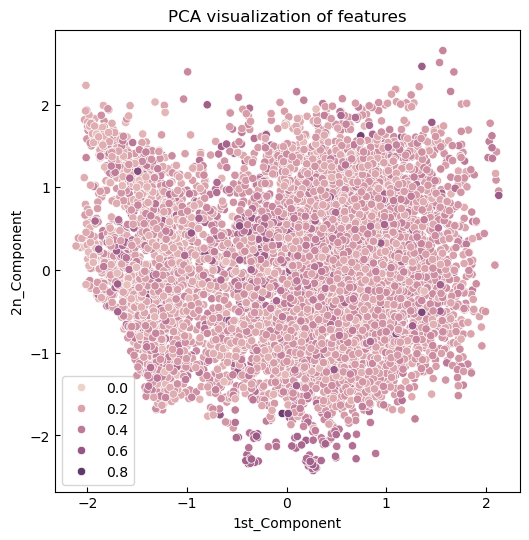

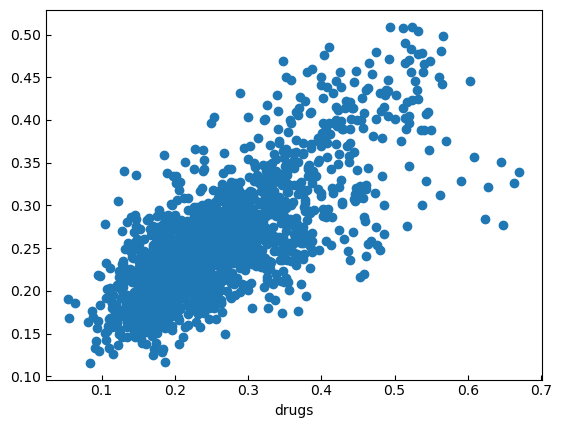

R2 score: 0.5514162406862346
Mean Squared Error: 0.00392092391689787


<Figure size 1400x400 with 0 Axes>

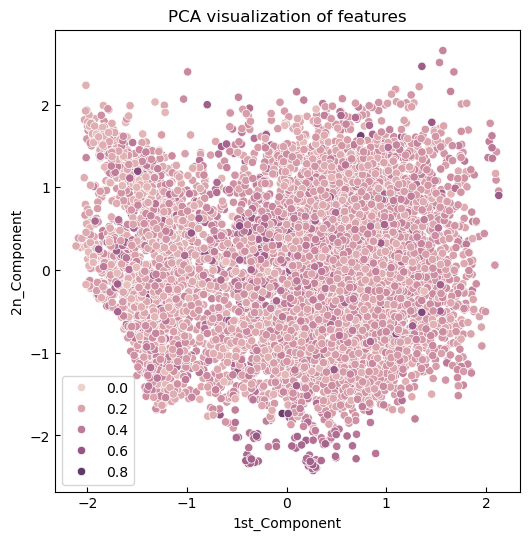

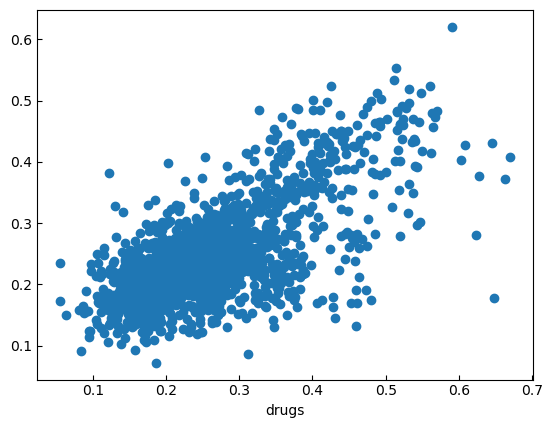

R2 score: 0.4655874128482901
Mean Squared Error: 0.00467112562804301


In [4]:
GBR_reg = ensemble.GradientBoostingRegressor(max_depth=7, n_estimators=500, learning_rate=0.3)
GBR_reg.fit(train_set, train_label)
gbr_pred = model_function(GBR_reg, train_set, train_label, test_set, test_label)

svr_reg = SVR(kernel='rbf', gamma='scale', C=0.1, epsilon=0.01)
svr_reg.fit(train_set, train_label)
svr_pred = model_function(svr_reg, train_set, train_label, test_set, test_label)

knn_reg = neighbors.KNeighborsRegressor(algorithm='kd_tree', n_neighbors= 5, weights='distance')
knn_reg.fit(train_set, train_label)
knn_pred = model_function(knn_reg, train_set, train_label, test_set, test_label)


In [14]:
param_grid = {
    'n_estimators': [100, 200, 300], # Number of boosting rounds
    'max_depth': [3, 4, 5],  # Maximum depth of a tree
    'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage
    'reg_alpha': [0, 0.1, 0.5],  # L1 regularization term on weights
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition
    'eval_metric': ['rmse', 'mae']  # Evaluation metrics
}
rnd_forest_blender = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
X_test_pred = np.empty((len(test_set), 3), dtype=np.float32)
X_test_pred[:, 0] = gbr_pred
X_test_pred[:, 1] = svr_pred
X_test_pred[:, 2] = knn_pred.squeeze(1)
grid_search = GridSearchCV(estimator=rnd_forest_blender, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_test_pred, test_label)
print('best parameters:', grid_search.best_params_)
# scores = cross_val_score(rnd_forest_blender, fingerprints, y_train.flatten(), cv=5, scoring='neg_mean_squared_error', error_score='raise')
# print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
[CV] END eval_metric=rmse, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0; total time=  43.4s
[CV] END eval_metric=rmse, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=300, reg_alpha=0.1; total time=   0.2s
[CV] END eval_metric=rmse, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=300, reg_alpha=0.1; total time=   0.2s
[CV] END eval_metric=rmse, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=300, reg_alpha=0.5; total time=   0.2s
[CV] END eval_metric=rmse, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=300, reg_alpha=0.5; total time=   0.2s
[CV] END eval_metric=rmse, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=300, reg_alpha=0.5; total time=   0.2s
[CV] END eval_metric=rmse, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=300, reg_alpha=0.5; total time=   0.2s
[CV] END eval_metric=rmse, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'eval_metric': ['rmse', 'mae'], 'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'reg_alpha': [0, 0.1, 0.5]},
             scoring='neg_mean_squared_error', verbose=2)

In [15]:
print('best parameters:', grid_search.best_params_)

best parameters: {'eval_metric': 'rmse', 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300, 'reg_alpha': 0}


In [17]:
from sklearn.ensemble import StackingRegressor
GBR_reg = ensemble.GradientBoostingRegressor(max_depth=7, n_estimators=500, learning_rate=0.3)

svr_reg = SVR(kernel='rbf', gamma='scale', C=0.1, epsilon=0.01)

knr_reg = neighbors.KNeighborsRegressor(algorithm='kd_tree', n_neighbors= 5, weights='distance')

final_estimator = xgb.XGBRegressor(objective="reg:squarederror", random_state=42,eval_metric='rmse',gamma=0, learning_rate=0.01, max_depth= 4, n_estimators= 300, reg_alpha= 0)
estimators = [('gbr', GBR_reg), ('svr', svr_reg), ('knn', knr_reg)]
reg = StackingRegressor(estimators=estimators, final_estimator=final_estimator)
reg.fit(train_set, train_label)
pred_test = reg.predict(test_set)
print('R2 score: {:.2f}'.format(r2_score(test_label, pred_test)))

/home/ipmgpu2022b/software/miniconda3/envs/digress/lib/python3.9/site-packages/sklearn/ensemble/_stacking.py:955: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2 score: 0.58


In [19]:
import joblib
joblib.dump(reg, '/raid/yyw/PharmDiGress/data/csd/cstacking_regressor_model.pkl')

['/raid/yyw/PharmDiGress/data/csd/cstacking_regressor_model.pkl']

In [2]:
import joblib
reg_tox = joblib.load('/raid/yyw/PharmDiGress/data/csd/cstacking_regressor_model.pkl')
smiles = ''
from rdkit import Chem
from rdkit.Chem import AllChem
mol = Chem.MolFromSmiles(smiles)
fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024)

In [8]:
reg_tox.predict([fingerprint]).item()

0.22043032944202423

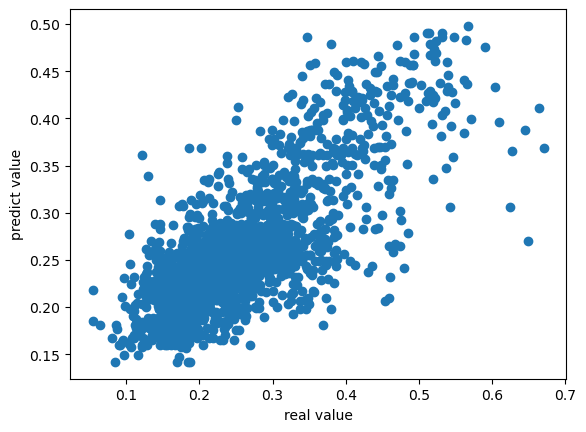

In [7]:
import joblib
reg_tox = joblib.load('/raid/yyw/PharmDiGress/data/stacking_regressor_model.pkl')
pred_test = reg_tox.predict(test_set)
plt.figure()
plt.scatter(test_label, pred_test.reshape(-1,1))
plt.xlabel('real value')
plt.ylabel('predict value')
plt.show()

In [6]:
print('R2 score: {}'.format(r2_score(test_label, pred_test)))
print("Mean Squared Error:", mean_squared_error(test_label.flatten(), pred_test))

R2 score: 0.5812809016178845
Mean Squared Error: 0.0036598866838600886
